In [1]:
from langchain_community.document_loaders import (
    UnstructuredHTMLLoader,
    BSHTMLLoader,
    TextLoader,
    JSONLoader,
)
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    MarkdownTextSplitter,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.vectorstores import Chroma
from langchain.chains import (
    RetrievalQA,
    ConversationalRetrievalChain,
    RetrievalQAWithSourcesChain,
)
from langchain.memory import ConversationBufferMemory
from langchain_community.llms import LlamaCpp
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import plot_example, score

import logging
import pickle


logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [2]:
retrieval_strategy = "mmr"
model = "mistral-7b-instruct-v0.2.Q4_K_M"

persist_directory = "./../embeddings"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [19]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        #self.responses["question"].append(llm_response["question"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        #self.responses["answer"].append(llm_response["answer"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses
    
    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Vector Retriever

In [5]:
with open(f"{persist_directory}/embeddings.pickle", 'rb') as handle:
    embeddings = pickle.load(handle)


In [6]:
vectordb = Chroma(
    "documents", # or "transcripts"
    embedding_function=embeddings,
    persist_directory=persist_directory,
    collection_metadata={"hnsw:space": "cosine"},
)

In [7]:
retriever = vectordb.as_retriever(
    search_type=f"{retrieval_strategy}",
    search_kwargs={"k": 5, "fetch_k": 20},
)

## Quantized Model

In [8]:
llm_open = LlamaCpp(
    #model_path=f"./../models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    model_path=f"/Users/arnewman/.cache/lm-studio/models/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    n_ctx=32768,  # 4096 for Llama, 32*1024 for Mistral
    n_gpu_layers=50,
    temperature=0.15,
    top_p=1,
    top_k=40,
    repeat_penalty=1.1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    stream=True,
)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! stream is not default parameter.
                stream was transferred to model_kwargs.
                Please confirm that stream is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /Users/arnewman/.cache/lm-studio/models/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embed

In [15]:
qa_chain = RetrievalQA.from_chain_type(
#qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
)

In [16]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:


In [17]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The class that involves time series analysis is Data Mining II (SIADS 632).


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       2.32 ms /    22 runs   (    0.11 ms per token,  9470.51 tokens per second)
llama_print_timings: prompt eval time =   19421.71 ms /   814 tokens (   23.86 ms per token,    41.91 tokens per second)
llama_print_timings:        eval time =     808.66 ms /    21 runs   (   38.51 ms per token,    25.97 tokens per second)
llama_print_timings:       total time =   20413.36 ms /   835 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
3. Big Data: Scalable Data Processing (SIADS 516): Grading
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Math Methods I (SIADS 502): Course Schedule


## Run the Model

In [18]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [20]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [21]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", 'wb') as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", 'wb') as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The class that involves time series analysis is Data Mining II (SIADS 632).


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      11.50 ms /    22 runs   (    0.52 ms per token,  1912.54 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =    1378.30 ms /    22 runs   (   62.65 ms per token,    15.96 tokens per second)
llama_print_timings:       total time =    1447.74 ms /    23 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
3. Big Data: Scalable Data Processing (SIADS 516): Grading
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Math Methods I (SIADS 502): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The instructor for the SQL and Databases class is Graham Hukill (gshukill@umich.edu).


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       2.61 ms /    26 runs   (    0.10 ms per token,  9969.33 tokens per second)
llama_print_timings: prompt eval time =   11047.21 ms /   531 tokens (   20.80 ms per token,    48.07 tokens per second)
llama_print_timings:        eval time =     929.68 ms /    25 runs   (   37.19 ms per token,    26.89 tokens per second)
llama_print_timings:       total time =   12115.87 ms /   556 tokens



> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Outcomes
3. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)
4. SQL and Databases (SIADS 511): Textbooks
5. SQL and Databases (SIADS 511): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The prerequisites for Data Science for Social Good include having completed SIADS 522 as a prerequisite. Additionally, students may benefit from having a foundational understanding of data science concepts and techniques. However, this is not a strict requirement, as the course is designed to be accessible to students with a variety of backgrounds and levels of prior knowledge in data science.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       8.01 ms /    81 runs   (    0.10 ms per token, 10109.84 tokens per second)
llama_print_timings: prompt eval time =   17198.35 ms /   827 tokens (   20.80 ms per token,    48.09 tokens per second)
llama_print_timings:        eval time =    3108.48 ms /    80 runs   (   38.86 ms per token,    25.74 tokens per second)
llama_print_timings:       total time =   20607.76 ms /   907 tokens



> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for SIADS 688: Data Science for Social Good Course Overview and Prerequisites
2. Communicating Data Science Results (SIADS 523): Course Syllabus SIADS 523: Communicating Data Science Results (Fall 2023) Course Overview And Prerequisites
3. n/a (n/a): Academics > Master of Applied Data Science (MADS) > Summary of Degree Requirements
4. Data Science Ethics (SIADS 503): Course Learning Outcomes
5. Data Science for Social Good (SIADS 688): Assignments And Grading You Are Expected To Read An Assigned Paper On Perusall Before Watching Each Lecture, And Complete A Problem Set Afterwards.


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The Math Methods course has weekly office hours via Zoom. The schedule includes Hanna Hoover on Wednesdays from 4:00-5:00 pm EST; Saurabh Budholiya on Fridays from 9:00-10:00 am EST; Alexis Castellanos on Saturdays from 3:00-4:00 pm EST. Office hours are recorded and archived for students who are unable to attend live sessions.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      11.81 ms /   108 runs   (    0.11 ms per token,  9147.12 tokens per second)
llama_print_timings: prompt eval time =   17864.39 ms /   859 tokens (   20.80 ms per token,    48.08 tokens per second)
llama_print_timings:        eval time =    4161.17 ms /   107 runs   (   38.89 ms per token,    25.71 tokens per second)
llama_print_timings:       total time =   22415.48 ms /   966 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Course Schedule
2. Unsupervised Learning (SIADS 543): Office Hours Schedule:
3. Experiment Design and Analysis (SIADS 631): Course Schedule
4. Causal Inference (SIADS 630): Office Hours:
5. Machine Learning Pipelines (SIADS 643): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 No, there are no weekly readings for Milestone II in this course.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       1.67 ms /    17 runs   (    0.10 ms per token, 10161.39 tokens per second)
llama_print_timings: prompt eval time =   14848.78 ms /   720 tokens (   20.62 ms per token,    48.49 tokens per second)
llama_print_timings:        eval time =     649.94 ms /    17 runs   (   38.23 ms per token,    26.16 tokens per second)
llama_print_timings:       total time =   15648.82 ms /   737 tokens



> Finished chain.


Sources:
1. Milestone II (SIADS 696): Weekly Readings
2. Milestone II (SIADS 696): Project Component
3. Milestone I (SIADS 593): 6.0 Office Hours
4. Milestone II (SIADS 696): Re-Grade Policy
5. Milestone I (SIADS 593): 7.0 Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The outcomes of Qualitative Inquiry include:
1. A deep understanding of the research problem or phenomenon from the perspective of the participants or stakeholders.
2. The identification and analysis of patterns, themes, and meanings in the data.
3. The development of a narrative or story that captures the essence of the research findings and communicates them effectively to various audiences.
4. The generation of insights and implications for practice, policy, and theory based on the research findings.
5. The dissemination and sharing of the research findings and insights with various stakeholders and communities through various channels and platforms such as academic publications, conferences, workshops, social media, blogs, and community engagement events.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      14.88 ms /   147 runs   (    0.10 ms per token,  9877.04 tokens per second)
llama_print_timings: prompt eval time =   24489.98 ms /  1176 tokens (   20.82 ms per token,    48.02 tokens per second)
llama_print_timings:        eval time =    5951.81 ms /   146 runs   (   40.77 ms per token,    24.53 tokens per second)
llama_print_timings:       total time =   30947.01 ms /  1322 tokens



> Finished chain.


Sources:
1. Qualitative Inquiry for Data Scientists (SIADS 601): Learning Outcomes
2. Qualitative Inquiry for Data Scientists (SIADS 601): Course Handouts
3. Qualitative Inquiry for Data Scientists (SIADS 601): Grading And Assignments Overview
4. Experiment Design and Analysis (SIADS 631): Learning Outcomes
5. Causal Inference (SIADS 630): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 There is no required textbook for SIADS 505. The weekly readings are a significant part of the course and should be referred to for course material.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       3.65 ms /    36 runs   (    0.10 ms per token,  9865.72 tokens per second)
llama_print_timings: prompt eval time =    7196.02 ms /   348 tokens (   20.68 ms per token,    48.36 tokens per second)
llama_print_timings:        eval time =    1280.65 ms /    35 runs   (   36.59 ms per token,    27.33 tokens per second)
llama_print_timings:       total time =    8605.74 ms /   383 tokens



> Finished chain.


Sources:
1. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
2. Applied Natural Language Processing (SIADS 655): Textbook Information
3. Presenting Uncertainty (SIADS 524): Required Textbook
4. Math Methods I (SIADS 502): Academic Integrity
5. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 There is no required textbook for Data Manipulation. The course relies on a variety of resources including online tutorials, videos, and articles. Additionally, students are encouraged to explore additional resources on their own to deepen their understanding of data manipulation techniques and concepts.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       5.88 ms /    57 runs   (    0.10 ms per token,  9692.23 tokens per second)
llama_print_timings: prompt eval time =   13324.40 ms /   648 tokens (   20.56 ms per token,    48.63 tokens per second)
llama_print_timings:        eval time =    2166.84 ms /    57 runs   (   38.01 ms per token,    26.31 tokens per second)
llama_print_timings:       total time =   15729.64 ms /   705 tokens



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Course Syllabus Course Overview And Prerequisites
2. Communicating Data Science Results (SIADS 523): Required Textbook
3. Data Manipulation (SIADS 505): Library Access
4. Math Methods II (SIADS 602): Textbooks For Optional Readings
5. Health Analytics (SIADS 681): Weekly Readings or Textbook Information


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The fourth week of unsupervised learning covers DBSCAN.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       1.71 ms /    13 runs   (    0.13 ms per token,  7597.90 tokens per second)
llama_print_timings: prompt eval time =    9502.31 ms /   458 tokens (   20.75 ms per token,    48.20 tokens per second)
llama_print_timings:        eval time =     443.65 ms /    12 runs   (   36.97 ms per token,    27.05 tokens per second)
llama_print_timings:       total time =   10062.81 ms /   470 tokens



> Finished chain.


Sources:
1. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 2
2. SQL and Databases (SIADS 511): Course Schedule
3. Unsupervised Learning (SIADS 543): Schedule
4. Learning Analytics and Educational Data Science (SIADS 680): Office Hours Via Zoom (Ann Arbor, Michigan Time - Eastern Time Zone)
5. Unsupervised Learning (SIADS 543): Quizzes


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To earn a Master of Applied Data Science degree from the University of Michigan School of Information, you must complete a minimum of 34 hours of graduate coursework, with a minimum cumulative grade average of B and a minimum grade of C- or greater in any course, including all required coursework. Note that within the 34 hours of graduate coursework, all 34 credits must be coursework taken within UMSI (SIADS credit). Additionally, you must complete all Milestone and Capstone courses. Currently MADS does not accept transfer credit of any kind including credit earned from other academic programs or MOOC certificates.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      13.73 ms /   134 runs   (    0.10 ms per token,  9760.36 tokens per second)
llama_print_timings: prompt eval time =   20757.07 ms /   994 tokens (   20.88 ms per token,    47.89 tokens per second)
llama_print_timings:        eval time =    5272.10 ms /   133 runs   (   39.64 ms per token,    25.23 tokens per second)
llama_print_timings:       total time =   26504.22 ms /  1127 tokens



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
2. n/a (n/a): Course Planning > Q: What is the recommended number of credits students should take?
3. n/a (n/a): Course Planning > Q: When will courses be offered next?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. Unsupervised Learning (SIADS 543): Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Students are expected to complete all coursework within five years from the date of first enrollment in the program. Students who exceed this time limit must file a petition for modification or waiver of policy. Petitions must describe explicitly the amount of work remaining and a timeline for completion. Students must be making good progress and have good academic standing to receive an extension. A student who does not complete degree requirements within five years and does not petition for an extension may be withdrawn from the program and required to apply for readmission.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      10.60 ms /   108 runs   (    0.10 ms per token, 10185.80 tokens per second)
llama_print_timings: prompt eval time =   19554.01 ms /   944 tokens (   20.71 ms per token,    48.28 tokens per second)
llama_print_timings:        eval time =    4245.82 ms /   108 runs   (   39.31 ms per token,    25.44 tokens per second)
llama_print_timings:       total time =   24189.09 ms /  1052 tokens



> Finished chain.


Sources:
1. n/a (n/a): General Academic Advising > Q: How long do I have to complete the program?
2. n/a (n/a): Course Planning > Q: How are the MADS courses/semesters set up?
3. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Leaving Course Channels


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The comprehensive oral exam is worth 40 points in SIADS 593.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =       2.08 ms /    20 runs   (    0.10 ms per token,  9615.38 tokens per second)
llama_print_timings: prompt eval time =   10661.91 ms /   517 tokens (   20.62 ms per token,    48.49 tokens per second)
llama_print_timings:        eval time =     704.13 ms /    19 runs   (   37.06 ms per token,    26.98 tokens per second)
llama_print_timings:       total time =   11494.30 ms /   536 tokens



> Finished chain.


Sources:
1. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade
2. Milestone II (SIADS 696): Comprehensive Exam Component
3. Milestone I (SIADS 593): 4.0 Weekly Readings
4. Unsupervised Learning (SIADS 543): Quizzes
5. Information Visualization I (SIADS 522): Letter Grades, Course Grades, And Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 In SIADS 630, there is a 15% daily-recurring reduction in grade for the first three days after the submission deadline. You will receive a zero (0) if your assignment is turned in four or more days late. Students have one free pass to submit all of one week's assessments late (up to three days). Students don't need to explain their circumstances but need to report their late submission by DMing Instructional team. Instructional team will adjust the late grade for one week's assessments.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      11.53 ms /   118 runs   (    0.10 ms per token, 10237.72 tokens per second)
llama_print_timings: prompt eval time =   19703.88 ms /   949 tokens (   20.76 ms per token,    48.16 tokens per second)
llama_print_timings:        eval time =    4613.97 ms /   117 runs   (   39.44 ms per token,    25.36 tokens per second)
llama_print_timings:       total time =   24717.60 ms /  1066 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties
2. Capstone (SIADS 699): Late Submission Policy
3. Causal Inference (SIADS 630): Late Policy
4. Milestone II (SIADS 696): Late Submission Policy
5. Presenting Uncertainty (SIADS 524): Late Submissions


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To request accommodations for a class due to a disability, follow these steps:
1. Complete the Student Application Form in Accommodate and meet with your assigned coordinator in the Services for Students with Disabilities office (SSD). Alternatively, provide documentation of your disability to your faculty instructor and to your academic advisor in the Office of Academic and Student Affairs to determine a reasonable accommodation. Note that UMSI reserves the right to require that you register with SSD and obtain approved accommodations.
2. Once your request for accommodations has been approved by your faculty instructor and by SSD (if applicable), your faculty instructor will provide you with any necessary accommodations, such as extended time on exams or alternative formats for course materials.
3. It is important to note that accommodations are designed to provide equal access and opportunity for students with disabilities, but they do not guarantee a perfect or ideal outcome. Accom


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      25.04 ms /   253 runs   (    0.10 ms per token, 10104.24 tokens per second)
llama_print_timings: prompt eval time =   18341.21 ms /   885 tokens (   20.72 ms per token,    48.25 tokens per second)
llama_print_timings:        eval time =    9940.66 ms /   252 runs   (   39.45 ms per token,    25.35 tokens per second)
llama_print_timings:       total time =   28963.43 ms /  1137 tokens



> Finished chain.


Sources:
1. n/a (n/a): Additional University Resources > Q: I need accommodations to best support my learning. Who can I talk to?
2. Data Science for Social Good (SIADS 688): Accommodations
3. n/a (n/a): Accommodations for Students with Disabilities Policy
4. n/a (n/a): Accommodations for Students with Disabilities Policy
5. Math Methods II (SIADS 602): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 A backpack is a type of bag with two straps that are worn on the back. Backpacks are commonly used for hiking, camping, and traveling, as they allow people to carry a large amount of gear and supplies with them in a convenient and comfortable way. Backpacks come in a wide range of sizes, styles, and features, so people can choose the one that best suits their needs and preferences.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      10.31 ms /    87 runs   (    0.12 ms per token,  8441.68 tokens per second)
llama_print_timings: prompt eval time =   11680.00 ms /   564 tokens (   20.71 ms per token,    48.29 tokens per second)
llama_print_timings:        eval time =    3255.21 ms /    86 runs   (   37.85 ms per token,    26.42 tokens per second)
llama_print_timings:       total time =   15200.64 ms /   650 tokens



> Finished chain.


Sources:
1. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
2. Milestone II (SIADS 696): Technology Tips
3. Visual Exploration of Data (SIADS 521): Use Of External Resources And Services (E.G Chatgpt)
4. Visual Exploration of Data (SIADS 521): Accessibility
5. Learning Analytics and Educational Data Science (SIADS 680): Library Access


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The deadline to submit a request for a late drop (withdrawal) is 11:59pm on the last day of classes for each session. However, if you intend to work on and submit an assignment after the official last day of the course (e.g. you use late days to complete a week 4 assignment past the deadline), you must make sure to start your work early enough that any assistance you might need from the instructional team can be obtained no later than the last official day of the course (i.e. stated close of the session). There is no guarantee that assistance from instructional staff will still be available after the last day of the course, since their time will already be occupied preparing for the next session's courses.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      15.62 ms /   157 runs   (    0.10 ms per token, 10048.00 tokens per second)
llama_print_timings: prompt eval time =   15004.47 ms /   724 tokens (   20.72 ms per token,    48.25 tokens per second)
llama_print_timings:        eval time =    6002.13 ms /   156 runs   (   38.48 ms per token,    25.99 tokens per second)
llama_print_timings:       total time =   21442.45 ms /   880 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
2. n/a (n/a): Class Registration > Q: What do I need to do to drop a course during the add/drop period?
3. Deep Learning I (SIADS 642): Course Schedule
4. n/a (n/a): Course Planning > Q: When will courses be offered next?
5. Unsupervised Learning (SIADS 543): Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To request an override for a class, you should first check if there are any seats available for registration through Wolverine Access. If there are no seats available and you still wish to take the class, then you should submit a request for an override through the UMSI Registrar Team at [umsi.registrar@umich.edu](mailto:umsi.registrar@umich.edu)]. In your request for an override, please provide your name, student ID number, term (fall, winter, or spring/summer), catalog number (e.g., SIADS 501), and section number (001, 002, etc.). Once your request for an override has been reviewed and approved by the instructor and the UMSI Registrar or your MADS academic advisor, then you will be notified and provided with instructions on how to register for the class through Wolverine Access. It is important to note that receiving an override does not enroll you in the course; you must register through Wolverine Access to claim the seat that has been opened for you.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      22.43 ms /   239 runs   (    0.09 ms per token, 10656.80 tokens per second)
llama_print_timings: prompt eval time =   21433.67 ms /  1031 tokens (   20.79 ms per token,    48.10 tokens per second)
llama_print_timings:        eval time =    9576.66 ms /   238 runs   (   40.24 ms per token,    24.85 tokens per second)
llama_print_timings:       total time =   31680.16 ms /  1269 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What is a Backpack?
2. n/a (n/a): Academics > Overrides/Permission to Enroll
3. Supervised Learning (SIADS 542): Grading And Course Checklist
4. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
5. n/a (n/a): Academics > Visiting (“Auditing”) a SIADS Course


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To request a leave of absence from the MADS program, you should first notify the MADS Academic Advising Team at [umsi.advising.mads@umich.edu](mailto:umsi.advising.mads@umich.edu)] of your intentions. If you have already registered for classes and need to withdraw from the MADS program, you will need to submit a term withdrawal form available from the UMSI Registrar Team (umsi.registrar@umich.edu).

To register for classes following a term in which you were not enrolled, you will need to contact the Office of the Registrar by email at [ro.registration.questions@umich.edu](mailto:ro.registration.questions@umich.edu)] or phone 734.764.6280 / 734.647.3507, to request a registration appointment assignment. If using email, please include name, UM ID number, term, and school or college in which you wish to register.

Students not enrolling within a year (12 months) will have to apply for readmission to UMSI.


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      27.59 ms /   266 runs   (    0.10 ms per token,  9640.13 tokens per second)
llama_print_timings: prompt eval time =   25912.88 ms /  1245 tokens (   20.81 ms per token,    48.05 tokens per second)
llama_print_timings:        eval time =   10954.38 ms /   265 runs   (   41.34 ms per token,    24.19 tokens per second)
llama_print_timings:       total time =   37747.25 ms /  1510 tokens



> Finished chain.


Sources:
1. n/a (n/a): Academics > Leave of Absence
2. n/a (n/a): Academics > Grades and Grading Policy > Grade of Incomplete (I)
3. n/a (n/a): Additional University Resources > Q: What mental health resources are available to MADS students?
4. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Practices > Acknowledge, even when you want to work on it later
5. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The prerequisites for Search and Recommender Systems include advisory prerequisites such as SIADS 642: Deep learning, SIADS 652: Network analysis, SIADS 655: Applied NLP, SIADS 611: Database Architecture and Technology, and enforced prerequisites such as SIADS 694 (first half of Milestone II).


llama_print_timings:        load time =    7565.42 ms
llama_print_timings:      sample time =      10.12 ms /    95 runs   (    0.11 ms per token,  9388.28 tokens per second)
llama_print_timings: prompt eval time =   14135.42 ms /   682 tokens (   20.73 ms per token,    48.25 tokens per second)
llama_print_timings:        eval time =    3578.01 ms /    94 runs   (   38.06 ms per token,    26.27 tokens per second)
llama_print_timings:       total time =   18052.33 ms /   776 tokens



> Finished chain.


Sources:
1. Search and Recommender Systems (SIADS 685): Course Overview And Prerequisites
2. Search and Recommender Systems (SIADS 685): Instructor And Course Assistants
3. Search and Recommender Systems (SIADS 685): Week 2: Retrieval Models, Web Search (Part I)
4. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
5. Data Science for Social Good (SIADS 688): Week 4 - Personalizing The Ask: Open Content, Recommender, And Reputation Systems


## Evaluation with BERTScore

In [22]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [23]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
 The class that involves time series analysis is Data Mining II (SIADS 632).


Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
 The instructor for the SQL and Databases class is Graham Hukill (gshukill@umich.edu).


What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------
 The prerequisites for Data Science for Social Good include having completed SIADS 522 as a prerequisite. 

In [24]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1, # 'Which class involves time series analysis?',
    1, # 'Who teaches the SQL and Databases class?',
    -1, # 'What are the prerequisites for Data Science for Social Good?',
    -1, # 'When are the office hours for the Math Methods course?',
    1, # 'Are there any weekly readings for Milestone II?',
    -1, # 'What are the outcomes of Qualitative Inquiry?',
    -1, # 'What textbook is required for SIADS 505?',
    -1, # 'What textbook is required for Data Manipulation?',
    -1, # 'Which week of unsupervised learning covers DBSCAN?',
    1, # 'How many credits are required to complete the MADS program?',
    1, # 'How long do students have to complete the MADS program start to finish?',
    -1, # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1, # 'What is the penalty for late submission in SIADS 630?',
    -1, # 'How do I get accommodations for a class?',
    -1, # 'What is a backpack?',
    1, # 'When is the latest I can drop a course?',
    1, # 'How do I get an override to take a class?',
    1, # 'How do I take a leave of absence from the MADS program?',
    1, # 'What are the prerequisites for Search and Recommender Systems?'
]

In [25]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

In [26]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

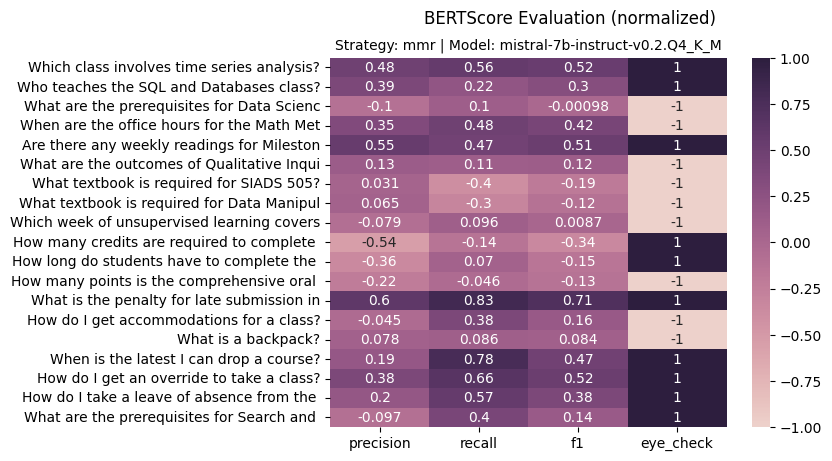

In [27]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()